# Demographic Research Methods and the PyCCM Library
## Computer Lab 4: Combining previous labs into a projection
## Instructor: Jiani Yan
## Date: October 30th, 2025
---

In this class, we are going to learn about how to do some fertility calculations in Python. As before, Section 1 is most important. We will try to finish both sections in the class, but it might be that later sections should be done as a 'class homework'. Solutions for all sections will either be presented at the start of the second day, or at the end of the class, time permitting.

Every ~15 minutes we'll stretch our legs, drink some water, and then live code up some answers so everybody can catch up. Relax, you're doing great!

In [1]:
import numpy as np
from pathlib import Path
import os

src_path= Path.cwd().parents[2]/'src'
data_path = Path.cwd().parents[2]/'data'

print(src_path)
os.chdir(src_path)

/Users/valler/Python/PyCCM/src


In [2]:
import numpy as np
import pandas as pd

from data_loaders import load_all_data
from abridger import unabridge_df
from fertility import compute_asfr, get_target_params
from mortality import make_lifetable
from helpers import _collapse_defunciones_01_24_to_04, _tfr_from_asfr_df, _smooth_tfr


## 1. Section 1: Loading data and unabridging

---

### 1.1 Load in the conteos.rds file, using the data_loaders module or otherwise.

In [3]:
df = load_all_data(data_path)['conteos']
df = pd.DataFrame(df)

### 1.2 Filter for your favorite DPTO. Lets focus on FEMALES first. Obtain one array/series for population counts, deaths, and fertility.

In [4]:
dpto = "BOLIVAR"
year = 2018 

df_dpto = df[(df["ANO"]==year)& (df['DPTO_NOMBRE']==dpto)].copy()

In [5]:
df_female = df_dpto[df_dpto['SEXO']==2].copy()

In [6]:
df_female['FUENTE'].unique()

array(['censo_2018', 'EEVV'], dtype=object)

In [7]:
df_pop_f = df_female[(df_female['FUENTE']=="censo_2018") & (df_female['VARIABLE']=='poblacion_total')].copy() # data source "FUENTE" is censo_{year} ; VARIABLE is poblacion_total

df_deaths_f  =  df_female[(df_female['FUENTE']=="censo_2018") & (df_female['VARIABLE']=='defunciones')].copy() # data source "FUENTE" is censo_{year}; VARIABLE is defunciones

df_births_f = df_female[(df_female['FUENTE']=="EEVV") & (df_female['VARIABLE']=='nacimientos')].copy() # data source "FUENTE" is EEVV; VARIABLE is nacimientos

In [8]:
df_births_f.head(2)

,OMISION,DPTO_NOMBRE,DPTO_CODIGO,ANO,EDAD,VARIABLE,VALOR,FUENTE,SEXO
34255,4.0,BOLIVAR,13.0,2018.0,10-14,nacimientos,166.0,EEVV,2.0
34257,4.0,BOLIVAR,13.0,2018.0,15-19,nacimientos,3449.0,EEVV,2.0


### 1.3 Unabridge each of these series using tools from PyCCM.

In [9]:
df_deaths_f['EDAD'].unique()

array(['0-1', '10-14', '15-19', '2-4', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49', '5-9', '50-54', '55-59', '60-64', '65-69',
       '70-74', '75-79', '80-84', '85-89', '90+', nan], dtype=object)

In [10]:
df_pop_f['EDAD'].unique()

array(['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74',
       '75-79', '80-84', '85-89', '90+', nan], dtype=object)

In [11]:
df_deaths_f_fixed = _collapse_defunciones_01_24_to_04(df_deaths_f) # combine the 0-1 and 2-4 to 0-4

In [12]:
df_deaths_f_fixed['EDAD'].unique()

array(['10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44',
       '45-49', '5-9', '50-54', '55-59', '60-64', '65-69', '70-74',
       '75-79', '80-84', '85-89', '90+', nan, '0-4'], dtype=object)

In [13]:
# unabridge 5-year age groups to 1 year age groups
df_deaths_f_1yr = unabridge_df(df_deaths_f_fixed, 
                           series_keys=["DPTO_NOMBRE","ANO","SEXO","VARIABLE","FUENTE"],
                           value_col = "VALOR")

In [14]:
len(df_deaths_f_1yr['EDAD'])

92

In [16]:
df_pop_f_1yr = unabridge_df(df_pop_f,
                           series_keys=["DPTO_NOMBRE","ANO","SEXO","VARIABLE","FUENTE"],
                           value_col = "VALOR")

In [17]:
len(df_pop_f_1yr['EDAD'])

92

In [36]:
df_births_f_1yr = unabridge_df(df_births_f,
                           series_keys=["DPTO_NOMBRE","ANO","SEXO","VARIABLE","FUENTE"],
                           value_col = "VALOR")

/Users/valler/Python/PyCCM/src/abridger.py:329: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([single, openp], ignore_index=True)


In [19]:
ages_1yr = [str(i) for i in range(90)]+['90+']

In [25]:
len(df_pop_f_1yr)

91

In [24]:
# delete nans 
df_pop_f_1yr = df_pop_f_1yr[df_pop_f_1yr['EDAD'].notna()]
df_deaths_f_1yr = df_deaths_f_1yr[df_deaths_f_1yr['EDAD'].notna()]

# sort the dfs 
df_pop_f_1yr.set_index('EDAD',inplace=True)
df_pop_f_1yr = df_pop_f_1yr.reindex(ages_1yr,fill_value=0)

df_deaths_f_1yr.set_index('EDAD',inplace=True)
df_deaths_f_1yr = df_deaths_f_1yr.reindex(ages_1yr,fill_value=0)


### 1.4 Use the code from labs 2 and 3 to calculate survivorship ratios and fertility rates just like before, but instead on un-abridged data.

In [28]:
lt_female = make_lifetable(ages = df_pop_f_1yr.index, 
                          population = df_pop_f_1yr['VALOR'].values,
                          deaths = df_deaths_f_1yr['VALOR'].values, 
                          radix = 100000)

In [43]:
len(df_pop_f_1yr)

91

In [31]:
# survivorship S_x = l_{x+1}/l_x
survivorship_f  = np.zeros(len(ages_1yr))
lx_values = lt_female['lx'].values

In [32]:
for i in range(len(ages_1yr)-1):
    if lx_values[i]>0:
        survivorship_f[i] = lx_values[i+1]/lx_values[i]
    else:
        survivorship_f[i] = 0.0
        

In [34]:
ex_last = lt_female.iloc[-1]['ex'] 
survivorship_f[-1] = np.exp(-1.0/ex_last)

In [37]:
births_f_by_age = df_births_f_1yr.groupby("EDAD")['VALOR'].sum()

In [38]:
asfr_result = compute_asfr(ages = births_f_by_age.index, 
                           population=df_pop_f_1yr['VALOR'],
                           births = births_f_by_age)

In [39]:
asfr_values = asfr_result['asfr'].values 
tfr_female = _tfr_from_asfr_df(asfr_result)

In [40]:
tfr_female

1.0843385511232186

### 1.5 This should give you the three things you need for creating a closed female only CCM:

* Counts
* Survivorship ratios
* ASFRs.

## 2. Section 2: Building our first Leslie Matrices

---

### 2.1 Define an empty numpy array of the appropriate size.

In [41]:
n_ages = len(ages_1yr)
leslie_matrix_f = np.zeros((n_ages,n_ages))

In [42]:
leslie_matrix_f

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(91, 91))

### 2.2 Survive your ASFRs as defined in the lecture

In [44]:
prop_female = 0.49 

In [45]:
survived_asfr = np.zeros(n_ages)

for i, age_str in enumerate(births_f_by_age.index.tolist()):
    age_idx = int(age_str)

    if age_idx < n_ages -1:
        survived_asfr[age_idx] =  (asfr_values[i]* prop_female * 
                                  (survivorship_f[age_idx]+survivorship_f[age_idx+1])/2)
    else:
        survived_asfr[age_idx] = asfr_values[i] * prop_female * survivorship_f[age_idx]
        

In [47]:
survived_asfr@df_pop_f_1yr['VALOR'].values

np.float64(8296.483750378884)

In [ ]:
survived_asfr

In [48]:
len([i for i in survived_asfr if i>0])

41

### 2.3 Position this corrected array into the appropriate place on the first row of the Leslie Matrix (noting early 0s)

In [49]:
leslie_matrix_f[0:] = survived_asfr

In [50]:
for i in range(n_ages -1): 
    leslie_matrix_f[i+1,i] = survivorship_f[i]
    
leslie_matrix_f[-1,-1] = survivorship_f[-1]

In [51]:
survivorship_f

array([0.99533301, 0.99588487, 0.99645745, 0.99742748, 0.9983227 ,
       0.99907652, 0.99964163, 0.99985603, 0.99990799, 0.99992127,
       0.99991029, 0.99984213, 0.9997122 , 0.99964289, 0.99962682,
       0.99963814, 0.99964974, 0.99964423, 0.99961212, 0.9995521 ,
       0.99947177, 0.99939093, 0.99933386, 0.99931354, 0.99931956,
       0.99932967, 0.99932218, 0.99928115, 0.9991964 , 0.99906947,
       0.99891632, 0.99876822, 0.99866176, 0.99862126, 0.99864312,
       0.99870468, 0.99877659, 0.99883307, 0.99885757, 0.99884596,
       0.99880114, 0.99873095, 0.99864642, 0.99855749, 0.99846566,
       0.99836592, 0.99824982, 0.99810887, 0.99793829, 0.99774205,
       0.99752992, 0.99731371, 0.99710253, 0.99689705, 0.99668343,
       0.99643971, 0.99614249, 0.99577353, 0.99532855, 0.99483126,
       0.99432871, 0.99388057, 0.99353825, 0.99331553, 0.99315713,
       0.99296293, 0.99261781, 0.9920135 , 0.99106691, 0.98976584,
       0.98818114, 0.98647574, 0.98486958, 0.98354439, 0.98251

In [52]:
print(leslie_matrix_f)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.99533301 0.         0.         ... 0.         0.         0.        ]
 [0.         0.99588487 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.90726476 0.         0.        ]
 [0.         0.         0.         ... 0.         0.89605853 0.38860952]]


In [53]:
population_f_next = leslie_matrix_f @ df_pop_f_1yr['VALOR'].values

In [61]:
population_f_next

array([ 8296.48375038, 24069.75814043, 24005.15975534, 23998.47363766,
       23998.0418358 , 23996.41888712, 24432.407681  , 25005.43856878,
       25499.67653231, 25792.65349985, 25848.86804684, 25718.76833177,
       25539.72861808, 25388.06581985, 25277.44691463, 25270.14164497,
       25328.04428951, 25369.14650327, 25339.97193422, 25215.55632111,
       24999.46132507, 24723.77617394, 24449.14590189, 24213.73887491,
       24033.00791305, 23899.52306382, 23783.16845328, 23631.33446895,
       23414.96196681, 23128.54939309, 22790.23704077, 22441.81186839,
       22148.66854438, 21947.05387863, 21843.87193184, 21816.51990171,
       21813.0144576 , 21752.12957872, 21584.96526176, 21295.04875946,
       20898.39675509, 20443.43494319, 20010.94112824, 19656.77040082,
       19411.80337087, 19281.88292179, 19247.85861777, 19265.6331272 ,
       19298.44508411, 19316.91078157, 19299.08266661, 19230.41514655,
       19103.71603619, 18916.25386411, 18669.26906655, 18368.77241034,
      

### 2.4 Position this updated array into the appropriate place on the first row of the Leslie Matrix (noting early 0s)

In [56]:
# <Your answer goes here>

### 2.5 Take your survivorship ratios. These don't need adjusting (here). Position them on the lower off-diagonal (i.e. A_{i+1, i} forall i \in{0, 90}).

In [57]:
# <Your answer goes here>

### 2.6 Multiply this matrix by your population count array.

In [58]:
len(df_pop_f_1yr['VALOR'].values)

91

In [59]:
df_pop_f_1yr['VALOR']

EDAD
0      15847.233202
1      15773.586309
2      15757.812723
3      15742.054910
4      15726.312855
           ...     
86      1362.149547
87      1212.859061
88      1066.138251
89       920.274049
90+     1505.000000
Name: VALOR, Length: 91, dtype: float64

In [60]:
projection_years = 50 
years_lst = [year+i for i in range(projection_years+1)]

projections_f = np.zeros((projection_years+1, n_ages))
projections_f[0,:]= df_pop_f_1yr['VALOR'].values

for t in range(projection_years):
    projections_f[t+1,:] = leslie_matrix_f @ projections_f[t,:]
    


In [64]:
len(years_lst)

51

In [70]:
projections_f[4,:]

array([28909.65967792, 47926.39997777, 60433.64113729, 68653.34763574,
       84320.95435044, 84355.73690453, 84446.84681019, 84526.82410776,
       84575.87313513, 85035.89535829, 85616.65259193, 86111.93780054,
       86400.8402663 , 86388.39047722, 85965.23744763, 85360.433955  ,
       84733.35621187, 84186.31206984, 83778.5397091 , 83469.86628937,
       83182.09078412, 82870.72045497, 82526.11367005, 82166.97364607,
       81833.39438988, 81581.03511189, 81434.09430571, 81386.95241655,
       81412.69179326, 81467.75657731, 81494.09145304, 81460.67575325,
       81363.08492875, 81219.87862385, 81070.42043506, 80974.11349893,
       80962.3292352 , 81040.12482531, 81186.31045483, 81352.42275165,
       81460.80629204, 81462.0131095 , 81332.75558543, 81078.56142182,
       80737.32704048, 80383.19533288, 80071.93503341, 79841.34526174,
       79706.53477961, 79656.88232001, 79654.6502884 , 79667.24480548,
       79667.17365604, 79633.21209719, 79548.69947832, 79404.17295301,
      

### 2.7 In a loop or otherwise (e.g. exponentiating the LM), to create multi-year projections

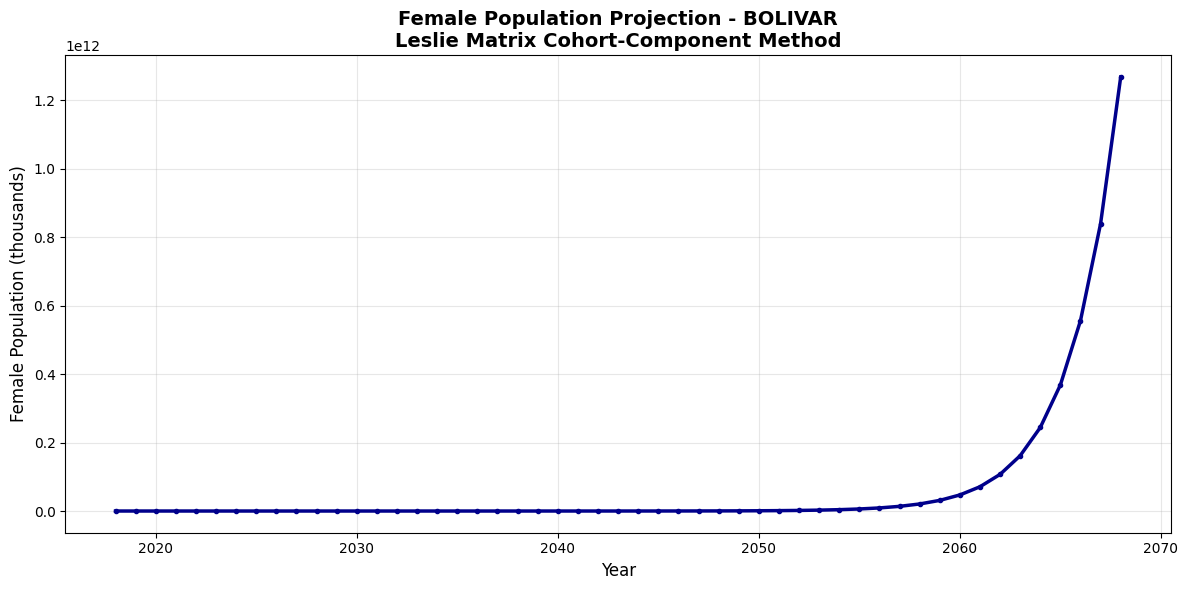

In [76]:
import matplotlib.pyplot as plt
# Visualize projection
total_pop_f = projections_f.sum(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(years_lst, total_pop_f / 1000, linewidth=2.5, color='darkblue', marker='o', markersize=3)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Female Population (thousands)', fontsize=12)
plt.title(f'Female Population Projection - {dpto}\n'
          f'Leslie Matrix Cohort-Component Method',
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Section 3: Repeat this exercise, but instead for Males. Note, here, that we need a MF leslie matrix to survive the women giving births to males. We also need to adjust our SRB!

In [12]:

# ---- code cell ----
print("\n" + "="*60)
print("Section 3: Building Leslie Matrix for MALES")
print("="*60)

# Get MALE data (SEXO = 1)
df_male = df_dpto[df_dpto['SEXO'] == 1.0].copy()

df_pop_m = df_male[(df_male['VARIABLE'] == 'poblacion_total') &
                   (df_male['FUENTE'] == f'censo_{year}')].copy()

df_deaths_m = df_male[(df_male['VARIABLE'] == 'defunciones') &
                      (df_male['FUENTE'] == f'censo_{year}')].copy()

# Unabridge male data
df_deaths_m_fixed = _collapse_defunciones_01_24_to_04(df_deaths_m)

df_pop_m_1yr = unabridge_df(
    df_pop_m,
    series_keys=['DPTO_NOMBRE', 'ANO', 'SEXO', 'VARIABLE', 'FUENTE'],
    value_col='VALOR',
    ridge=1e-6
)

df_deaths_m_1yr = unabridge_df(
    df_deaths_m_fixed,
    series_keys=['DPTO_NOMBRE', 'ANO', 'SEXO', 'VARIABLE', 'FUENTE'],
    value_col='VALOR',
    ridge=1e-6
)

# Build male life table
pop_m_by_age = df_pop_m_1yr.groupby('EDAD')['VALOR'].sum()
deaths_m_by_age = df_deaths_m_1yr.groupby('EDAD')['VALOR'].sum()

# Filter out NaN ages and align to expected age range
pop_m_by_age = pop_m_by_age[pop_m_by_age.index.notna()]
deaths_m_by_age = deaths_m_by_age[deaths_m_by_age.index.notna()]

# Reindex to ensure we have all ages
pop_m_by_age = pop_m_by_age.reindex(ages_1yr, fill_value=0.0)
deaths_m_by_age = deaths_m_by_age.reindex(ages_1yr, fill_value=0.0)

lt_male = make_lifetable(
    ages=pop_m_by_age.index,  # Pass the age index
    population=pop_m_by_age.values,
    deaths=deaths_m_by_age.values,
    radix=100000,
    use_ma=True,
    ma_window=5
)

print(f"\n✓ Male life table calculated:")
print(f"  Male life expectancy (e_0): {lt_male.iloc[0]['ex']:.2f} years")

# Calculate male survivorship ratios
survivorship_m = np.zeros(len(ages_1yr))
lx_values_m = lt_male['lx'].values

for i in range(len(ages_1yr) - 1):
    if lx_values_m[i] > 0:
        survivorship_m[i] = lx_values_m[i + 1] / lx_values_m[i]
    else:
        survivorship_m[i] = 0.0

ex_last_m = lt_male.iloc[-1]['ex']
if ex_last_m > 0:
    survivorship_m[-1] = np.exp(-1.0 / ex_last_m)
else:
    survivorship_m[-1] = 0.0

# Create male population vector
population_m = pop_m_by_age.reindex(ages_1yr, fill_value=0.0).values

print(f"  Total male population: {population_m.sum():,.0f}")
print(f"  Infant survival (age 0→1): {survivorship_m[0]:.4f}")

# Build male Leslie matrix
# Note: Males are born from FEMALE fertility, so first row uses female ASFR
leslie_matrix_M = np.zeros((n_ages, n_ages))

# Male births from female fertility (proportion male = SRB / (1 + SRB))
prop_male = srb / (1.0 + srb)

# Survived ASFR for male births
survived_asfr_m = np.zeros(n_ages)
for i, age_str in enumerate(reproductive_ages):
    age_idx = int(age_str)
    if age_idx < n_ages - 1:
        survived_asfr_m[age_idx] = (
            asfr_values[i] * prop_male *
            (survivorship_m[age_idx] + survivorship_m[age_idx + 1]) / 2
        )
    else:
        survived_asfr_m[age_idx] = asfr_values[i] * prop_male * survivorship_m[age_idx]

# Place in first row
leslie_matrix_M[0, :] = survived_asfr_m

# Male survivorship on sub-diagonal
for i in range(n_ages - 1):
    leslie_matrix_M[i + 1, i] = survivorship_m[i]

leslie_matrix_M[-1, -1] = survivorship_m[-1]

print(f"\n✓ Male Leslie Matrix complete")
print(f"  Proportion male births: {prop_male:.3f}")

# Project males
projections_m = np.zeros((projection_years + 1, n_ages))
projections_m[0, :] = population_m

for t in range(projection_years):
    projections_m[t + 1, :] = leslie_matrix_M @ projections_m[t, :]

total_pop_m = projections_m.sum(axis=1)

print(f"\n✓ Male projections complete:")
print(f"  Start year {year}:        {total_pop_m[0]:,.0f}")
print(f"  End year {year+projection_years}:          {total_pop_m[-1]:,.0f}")


## 4. Section 4: Combine projections from Males and Females to give a total population projection for multiple years. Visualise this.

In [13]:
# <Your answer goes here>

## 5. Section 5: Add half of the migration array to the exposures for both mortality and fertility, male and female.

In [14]:
# <Your answer goes here>

## 6. Section 6: Incorporate MA mortality smoothing and target mortality improvements/fertility adjustments over time.

In [15]:
# <Your answer goes here>

## 7. Section 7. Account for Omissions. Congratulations; you've just replicated PyCCM :)

In [16]:
# <Your answer goes here>